# Hessian Weight Averaged Gaussian Calculation of Prediction Uncertainty

Ashley S. Dale

Notebook loads a pretrained ALIGNN model, and calculates the uncertainty in model predictions using Hessian Loss Landscapes.

- Relevant Paper: [*A Simple Baseline for Bayesian Uncertainty in Deep Learning* by Maddox et al.](https://proceedings.neurips.cc/paper_files/paper/2019/hash/118921efba23fc329e6560b27861f0c2-Abstract.html)
- Relevant Paper: [*Stochastic Weight Perturbations Along the Hessian: A Plug-and-Play Method to Compute Uncertainty* by Ravishankar et al.](https://link.springer.com/chapter/10.1007/978-3-031-16749-2_8). 

Instead of using SGD to obtain an ensemble of models from which to calculate a distribution $\mathcal{N}(\mu_{\theta}, \sigma_{\theta})$, where $\theta$ represents the set of all parameters in the ensemble, this code uses the loss landscape to identify which models have similar performance.

---

Notebook Outline:

0. Select and load trained model and data

0. Generate a set of predictions for the data

0. Select a subset of well predicted instances to be "In Distribution" (ID) based on the z-score of the prediction error, where low z-score represents well predicted and therefore in-distribution

0. Select a subset of poorly predicted instances to be "Out of Distribution" (OOD) based on the z-score of the prediction error, where a high z-score represents poorly predicted samples that are therefore out-of-distribution

0. Calculate two eigenvectors of the Hessian for the model weights

0. Calculate the loss landscape, an average model from the loss landscape, and a standard deviation of the models used for the average

0. Use the average model and the standard deviation model to create an distribution of models 

0. Sample the distribution of models to generate new models with similar performance as the original model

0. Use the sampled model to generate new sets of predictions for each sample in the dataset

0. Find the standard deviation of the set of predictions for each sample in the dataset

In [1]:
import copy
import torch
import glob
import json

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pandas import DataFrame
import ipywidgets as widgets

from alignn.pretrained import *

from src.utils import *
from src import botcher_hessian_alignn as hess
from src import botcher_utilities as util
from src.hessian_wag import get_hessian_wag
from src.hessian_wag import get_sample_from_normal_dist_of_models

In [2]:
device = 'cpu'

# Load Model

-> Select the `jv_formation_energy_peratom_alignn` model for the demo

In [3]:
style = {'description_width': 'initial'}

config_selector = widgets.Dropdown(
    options=list(get_all_models().keys()),
    value=list(get_all_models().keys())[0],
    description='Select Model',
    style=style,
    disabled=False,
)

display(config_selector)

Dropdown(description='Select Model', options=('jv_formation_energy_peratom_alignn', 'jv_optb88vdw_total_energy…

In [4]:
# This is the model we will load
model_name = config_selector.value
print("Selected: ", model_name)

Selected:  jv_formation_energy_peratom_alignn


In [5]:
model, model_wt_dict = load_pretrained_model(model_name)

Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path /Users/ashley/miniconda/envs/loss_landscapes_demo/lib/python3.10/site-packages/alignn/jv_formation_energy_peratom_alignn.zip
Config /Users/ashley/AUTODIAL/loss_landscapes_demo/jv_formation_energy_peratom_alignn/config.json


# Load Data

In [6]:
# target = 'optb88vdw_bandgap'
target = 'formation_energy_peratom'
n_samples = 100 # for all samples, pass -1
element_to_omit_from_training_data = 'Fe'

In [7]:
train_data_list, test_data_list = load_data(
    element_to_omit_from_training_data, n_samples
)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
num train samples: 94
num test samples: 6


In [8]:
train_dataloader = get_data_loader(train_data_list, target)

data range 2.71694 -3.52032
Converting to graphs!


100%|██████████| 94/94 [00:01<00:00, 87.34it/s]


df                                                 atoms     prop jid
0   {'lattice_mat': [[3.566933224304235, 0.0, -0.0... -0.42762   0
1   {'lattice_mat': [[4.089078911208881, 0.0, 0.0]... -0.41596   1
2   {'lattice_mat': [[-1.833590720595598, 1.833590...  0.04847   2
3   {'lattice_mat': [[7.2963518353359165, 0.0, 0.0... -0.44140   3
4   {'lattice_mat': [[1.6777483798834445, -2.90594... -0.71026   4
..                                                ...      ...  ..
89  {'lattice_mat': [[3.4588203388948178, -5.99085... -1.05977  89
90  {'lattice_mat': [[4.551532451660252, -1.523515... -0.45383  90
91  {'lattice_mat': [[5.9690622474184964, -1.10662... -1.41944  91
92  {'lattice_mat': [[4.441434772806991, 0.0, -0.0... -0.69108  92
93  {'lattice_mat': [[4.2978053886009535, -1.21972... -0.59934  93

[94 rows x 3 columns]
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
building line 

100%|██████████| 94/94 [00:00<00:00, 2169.01it/s]


# Predicting on Test and Train Data

In [9]:
model_train_predictions = []
original_train_targets = []
for s in tqdm(train_dataloader):
    original_train_targets.append(s[2].detach().numpy()[0])
    y_pred = np.expand_dims(model([s[0].to(device), s[1].to(device)]).detach().numpy(), axis=0)[0]
    model_train_predictions.append(y_pred)

100%|██████████| 94/94 [00:04<00:00, 19.67it/s]


In [10]:
test_dataloader = get_data_loader(test_data_list, target)

model_test_predictions = []
original_test_targets = []
for s in tqdm(test_dataloader):
    original_test_targets.append(s[2].detach().numpy()[0])
    y_pred = np.expand_dims(model([s[0].to(device), s[1].to(device)]).detach().numpy(), axis=0)[0]
    model_test_predictions.append(y_pred)


data range 0.07844 -2.4143
Converting to graphs!


100%|██████████| 6/6 [00:00<00:00, 42.51it/s]


df                                                atoms     prop jid
0  {'lattice_mat': [[3.790914410660539, -0.0, 0.0... -2.07159   0
1  {'lattice_mat': [[4.927781968323723, -0.0, 0.0... -1.78124   1
2  {'lattice_mat': [[4.839493559425439, 9.7116505... -1.66274   2
3  {'lattice_mat': [[5.464512229851642, 0.0, -2.0... -0.93989   3
4  {'lattice_mat': [[4.078736102710052, 0.3455178...  0.07844   4
5  {'lattice_mat': [[2.80754625599962, 0.0, 0.0],... -2.41430   5
building line graphs


100%|██████████| 6/6 [00:00<00:00, 13.71it/s]


## Subselect Train Data Samples: Most ID (Minimum Error)

In [11]:
train_df = pd.DataFrame(train_data_list)
train_df['pred_val'] = model_train_predictions
train_df['err'] = (train_df[target] - train_df['pred_val'])
train_df['abs_err'] = np.abs(train_df[target] - train_df['pred_val'])
train_df['z_score_err'] = (train_df['abs_err'] - np.mean(train_df['abs_err']))/np.std(train_df['abs_err'])

In [12]:
train_subset_dataloader = load_zscore_sample(train_df, train_data_list, 10, target, 'low')

data range 2.71694 -2.05294
Converting to graphs!


100%|██████████| 10/10 [00:00<00:00, 88.55it/s]


df                                                atoms     prop jid
0  {'lattice_mat': [[10.725911963093319, 1.159968... -0.34176   0
1  {'lattice_mat': [[-0.0, 4.981020994615496, 4.9...  0.65832   1
2  {'lattice_mat': [[0.0, 5.104615296684174, 5.10...  0.35284   2
3  {'lattice_mat': [[4.927229198330356, -0.0, -0.... -1.32124   3
4  {'lattice_mat': [[-3.8661597507471313, -3.8661...  2.71694   4
5  {'lattice_mat': [[4.376835486482439, 0.0086562... -0.00064   5
6  {'lattice_mat': [[4.284492173131309, 1.636192e... -0.42539   6
7  {'lattice_mat': [[4.441434772806991, 0.0, -0.0... -0.69108   7
8  {'lattice_mat': [[1.6712283e-08, -2.5080296697...  0.00009   8
9  {'lattice_mat': [[5.194393535053021, 0.0345773... -2.05294   9
building line graphs


100%|██████████| 10/10 [00:00<00:00, 2084.23it/s]


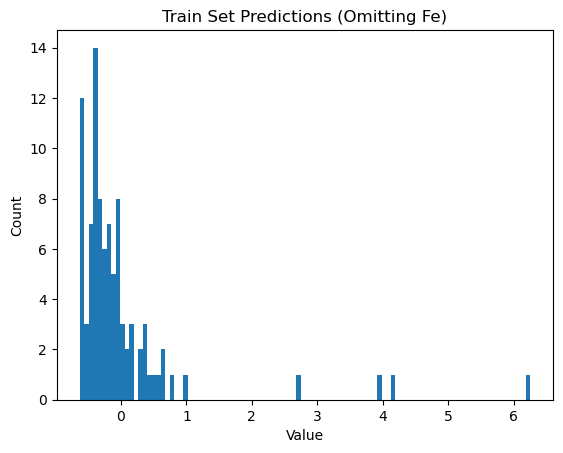

In [13]:
plt.hist(train_df['z_score_err'].values, bins=100)
plt.title('Train Set Predictions (Omitting '+element_to_omit_from_training_data+')')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

In [14]:
subset_train_x = []
subset_train_y = []

for i in train_subset_dataloader:
    subset_train_x.append((i[0], i[1]))
    subset_train_y.append(i[2])

## Subselect Test Samples - Most OOD (Maximum Error)

In [15]:
test_df = pd.DataFrame(test_data_list)
test_df['pred_val'] = model_test_predictions
test_df['err'] = (test_df[target] - test_df['pred_val'])
test_df['abs_err'] = np.abs(test_df[target] - test_df['pred_val'])
test_df['z_score_err'] = (test_df['abs_err'] - np.mean(train_df['abs_err']))/np.std(train_df['abs_err'])

In [16]:
test_subset_dataloader = load_zscore_sample(test_df, test_data_list, 10, target, 'high')

data range 0.07844 -2.4143
Converting to graphs!


100%|██████████| 6/6 [00:00<00:00, 57.99it/s]


df                                                atoms     prop jid
0  {'lattice_mat': [[3.790914410660539, -0.0, 0.0... -2.07159   0
1  {'lattice_mat': [[4.078736102710052, 0.3455178...  0.07844   1
2  {'lattice_mat': [[4.839493559425439, 9.7116505... -1.66274   2
3  {'lattice_mat': [[4.927781968323723, -0.0, 0.0... -1.78124   3
4  {'lattice_mat': [[2.80754625599962, 0.0, 0.0],... -2.41430   4
5  {'lattice_mat': [[5.464512229851642, 0.0, -2.0... -0.93989   5
building line graphs


100%|██████████| 6/6 [00:00<00:00, 1341.10it/s]


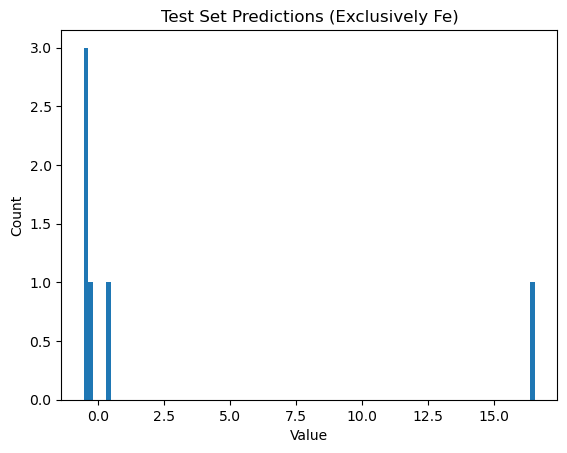

In [17]:
plt.hist(test_df['z_score_err'].values, bins=100)
plt.title('Test Set Predictions (Exclusively '+element_to_omit_from_training_data+')')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()

# Getting the Hessian Eigenvectors

In [18]:
### Defaults from OG implementation
loss_func = torch.nn.MSELoss()
func = copy.deepcopy(model)

This next cell calculates the eigenvectors, and can take considerable time (upwards of 40 minutes)

In [19]:
train_hess_1, train_hess_2 = get_hessians(func, train_subset_dataloader, model_wt_dict, loss_func)

3996416
<All keys matched successfully>
<All keys matched successfully>


# Create 2D Directed Loss Surface

In [20]:
STEPS = 10

In [21]:
loss_landscape, mu_model, stddev_model, model_loci = get_hessian_wag(
    train_subset_dataloader, loss_func, func, STEPS, train_hess_1, train_hess_2, loss_threshold=10
)

Getting Averaged Model: 100%|██████████| 10/10 [01:52<00:00, 11.24s/it]


get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed model issue
get normed 

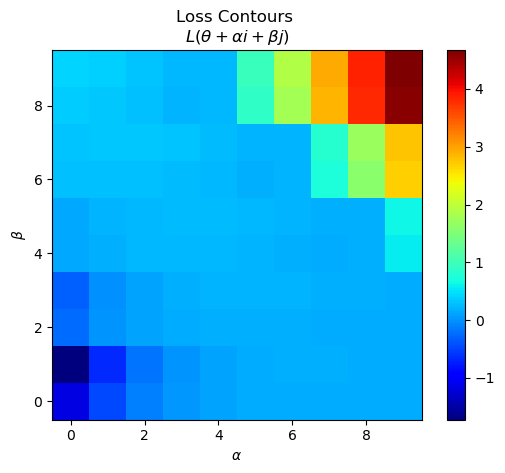

In [22]:
save_fig_name = os.path.join('loss_contours.png')
fig, ax = plt.subplots(1, 1)
plt.imshow(np.log10(loss_landscape), origin='lower', cmap='jet')
ax.set_title('Loss Contours \n'+ r'$L(\theta + \alpha i + \beta j$)')
ax.axis('square')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
plt.colorbar()
fig.savefig(save_fig_name, transparent=True, dpi=300)
plt.show()

# Generate Distribution of Models & Predictions

In [23]:
plot_model_wt_dist(stddev_model)

ValueError: autodetected range of [nan, nan] is not finite

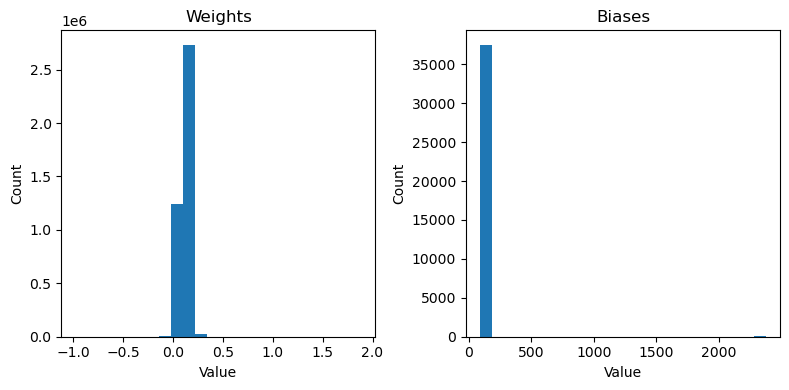

avg wt val:  0.018074161271373398
std wt val:  6.355362099541208


In [24]:
plot_model_wt_dist(mu_model)

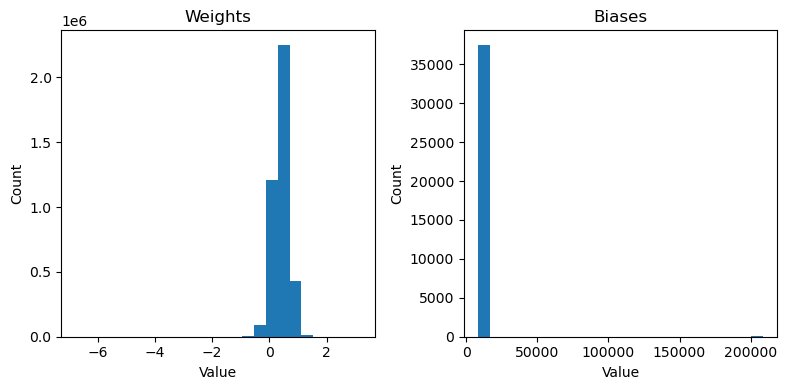

avg wt val:  1.7287125096372333
std wt val:  559.4174772002824


In [25]:
plot_model_wt_dist(model)

In [26]:
torch.save(mu_model.state_dict(), 'mu_model.pt')

In [ ]:
# torch.save(stddev_model.state_dict(), 'stddev_model.pt')

In [ ]:
norm_dist_model = get_sample_from_normal_dist_of_models(mu_model, stddev_model, model)
plot_model_wt_dist(norm_dist_model)

In [ ]:
def get_prediction_stddev(data_loader, mu_model, stddev_model, model):
    sampled_model = get_sample_from_normal_dist_of_models(mu_model, stddev_model, model)
    plot_model_wt_dist(sampled_model)

    model_new_train_predictions = []
    original_train_targets = []
    for s in tqdm(train_dataloader):
        original_train_targets.append(s[2].detach().numpy()[0])
        y_pred = np.expand_dims(sampled_model([s[0].to(device), s[1].to(device)]).detach().numpy(), axis=0)[0]
        model_new_train_predictions.append(y_pred)

    return model_new_train_predictions    

In [ ]:
pred_set = []
for _ in range(10):
    new_pred = get_prediction_stddev(train_dataloader, mu_model, stddev_model, model)
    pred_set.append(new_pred)
    break


In [ ]:
pred_set

In [ ]:
plt.hist(np.std(np.array(pred_set), axis=0), bins=25)